In [1]:
import pandas as pd
import torch#深度学习的pytoch平台
import torch.nn as nn
import numpy as np
import random
import os
import time#可以用来简单地记录时间
import matplotlib.pyplot as plt#画图
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
from models.dual_adaptation_gate import DAG_Tabular, TabTransformer, mm_tab
from models.train_and_test_step import train_model, test_model, evaluate_model, plot_result

In [3]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import torchvision
import torchvision.transforms as transforms

# 加载数据

In [4]:
file_path = '../datasets/mimic/'
df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_val = pd.read_csv(file_path + 'val.csv')

# Check device

In [5]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()
    
# Set the seed value all over the place to make this reproducible.
seed_val = 23#43

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
os.environ['PYTHONHASHSEED'] = str(seed_val)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA GeForce GTX 1080 Ti


# Define hybrid parameters

In [6]:
batch_size = 64
epochs = 20
learning_rate = 1e-3 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df_train) / batch_size / 1 * epochs)
num_workers = 0

# Load data

In [7]:
cat_cols = ["admission_type", 'gender', 'ethnicity', # 'marital_status', "insurance", "language",
            "electivesurgery", "vent",
#             'vasopressor', 'milrinone', 'furosemide',  # 升压药、强心剂、利尿剂
            'activity','fall_risk',
#             'braden_nutrition', 'braden_mobility', 'braden_activity',
#             'lll_lung_sounds','lul_lung_sounds','rll_lung_sounds', 'rul_lung_sounds'
           ]

numerical_cols = ["pre_icu_los_day",'age','weight', #'spo2_fio2_ratio',
                  'bmi', 'creatinine_max', 'bilirubin_max',
                  'platelet_min', 'bun_max', 'wbc_max', 'glucose_max',
                  'hematocrit_max', 'potassium_max', 'sodium_max', 'bicarbonate_min', 'bicarbonate_max',
                  'pao2fio2ratio_vent', 'albumin_min', 'alt_max', 'ast_max', 'alp_max', 'pt_max',
                  'ptt_max', 'inr_min', 'hemoglobin_min', 'chloride_min', 'pao2_min', 'paco2_max', 'lactate_max',
                  'baseexcess_min', 'fio2_max', 'troponin_max', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_min',
                  'magnesium_max','aniongap_max', 'gcs_min',
                  'urineoutput', 'spo2_min', 'heart_rate_mean', 'mbp_mean',
                  'sbp_mean', 'resp_rate_mean', 'temperature_mean',
                  'cci_score',
                ]

tabular_cols = cat_cols + numerical_cols

In [8]:
X_train = df_train.loc[:, tabular_cols]
X_val = df_val.loc[:, tabular_cols]
X_test = df_test.loc[:, tabular_cols]

y_train = df_train['death_hosp']
y_val = df_val['death_hosp']
y_test = df_test['death_hosp']

In [9]:
y_train.value_counts()

0    7750
1    1228
Name: death_hosp, dtype: int64

In [11]:
y_val.value_counts()

0    969
1    154
Name: death_hosp, dtype: int64

In [10]:
y_test.value_counts()

0    969
1    153
Name: death_hosp, dtype: int64

# Tabular to Image

E:\Program_Files\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


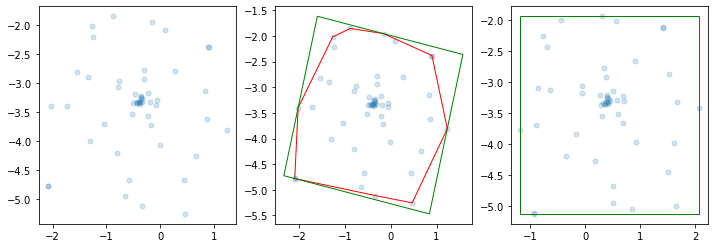

In [9]:
# Normalize data using LogScaler
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_val_norm = ln.transform(X_val)
X_test_norm = ln.transform(X_test)

# Create t-SNE object
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1,
    random_state=seed_val
)

# Initialize image transformer
pixel_size = ( 8, 8)
it = ImageTransformer(
    feature_extractor=reducer, 
#     feature_extractor='pca',
    pixels=pixel_size)

it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_val_img = it.transform(X_val_norm)
X_test_img = it.transform(X_test_norm)

In [10]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
train_img = torch.stack([preprocess(img) for img in X_train_img]).float()
val_img = torch.stack([preprocess(img) for img in X_val_img]).float()
test_img = torch.stack([preprocess(img) for img in X_test_img]).float()

# Make dataset

In [12]:
def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

train_cat = torch.tensor(np.array(df_train.loc[:, cat_cols],dtype=np.int32))
train_num = torch.tensor(np.array(df_train.loc[:, numerical_cols],dtype=np.float32))
train_y = torch.tensor(df_train.death_hosp.astype(int).tolist())

val_cat = torch.tensor(np.array(df_val.loc[:, cat_cols],dtype=np.int32))
val_num = torch.tensor(np.array(df_val.loc[:, numerical_cols],dtype=np.float32))
val_y = torch.tensor(df_val.death_hosp.astype(int).tolist())

test_cat = torch.tensor(np.array(df_test.loc[:, cat_cols],dtype=np.int32))
test_num = torch.tensor(np.array(df_test.loc[:, numerical_cols],dtype=np.float32))
test_y = torch.tensor(df_test.death_hosp.astype(int).tolist())

In [13]:
# wrap tensors
train_data = TensorDataset(train_cat, train_num, train_img, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_cat, val_num, val_img, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_cat, test_num, test_img, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

In [14]:
print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 141
Number of data in the validation set 18
Number of data in the test set 18


# Load model

In [15]:
model = mm_tab(categories = (2,2,2,2,2,2,2),      # tuple containing the number of unique values within each category
                        num_continuous = 45,                # number of continuous values
                        dim = 16,                           # dimension, paper set at 32
                        dim_out = 1,                        # binary prediction, but could be anything
                        depth = 1,                          # depth, paper recommended 6
                        heads = 1,                          # heads, paper recommends 8
                        attn_dropout = 0.1,                 # post-attention dropout
                        ff_dropout = 0.1,                   # feed forward dropout
                        mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
                      )
model.to(device) # Model to GPU.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

E:\Program_Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
E:\Program_Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def training_model(model, traindata, bceloss, optimizer, epochs=12):
    # for each epoch perform training and evaluation
    for epoch in range(epochs):
        #train model
        train_loss, _ = train_model(model, traindata, bceloss, optimizer)
        
def evaluate_models_with_auc(model, test_data, df_data):
    preds = test_model(model, test_data)
    
    fpr, tpr, thresholds = roc_curve(df_data['death_hosp'], preds[0])
    auc_score = auc(fpr, tpr)
    return auc_score

In [17]:
bceloss  = nn.BCELoss()

In [18]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train_model(model, traindata, bceloss, optimizer)
    
    #evaluate model
    valid_loss, _ = evaluate_model(model, valdata, bceloss)
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
Training...
  Batch    50  of    141. loss 0.34308701753616333
  Batch   100  of    141. loss 0.3415094017982483

Evaluating...
Evaluation done for epoch 1

Training Loss: 0.394
Validation Loss: 0.334

 Epoch 2 / 20
Training...
  Batch    50  of    141. loss 0.2838607430458069
  Batch   100  of    141. loss 0.307162344455719

Evaluating...
Evaluation done for epoch 2

Training Loss: 0.339
Validation Loss: 0.327

 Epoch 3 / 20
Training...
  Batch    50  of    141. loss 0.3888273239135742
  Batch   100  of    141. loss 0.3521885573863983

Evaluating...
Evaluation done for epoch 3

Training Loss: 0.322
Validation Loss: 0.332

 Epoch 4 / 20
Training...
  Batch    50  of    141. loss 0.36541152000427246
  Batch   100  of    141. loss 0.31484323740005493

Evaluating...
Evaluation done for epoch 4

Training Loss: 0.322
Validation Loss: 0.339

 Epoch 5 / 20
Training...
  Batch    50  of    141. loss 0.3608342111110687
  Batch   100  of    141. loss 0.25536030530929565

Evaluatin

In [19]:
preds = test_model(model, testdata)


Test Set...
Total batches: 18
Batch 18
Prediction complete.


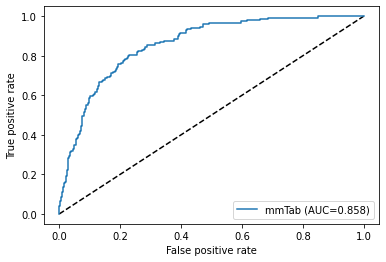

In [20]:
plot_result(df_test['death_hosp'], preds[0])

# 外部验证

In [12]:
df_external = pd.read_csv(file_path + 'external.csv')
df_temporal = pd.read_csv(file_path + 'mimiciv_temporal_data_preprocess.csv')

In [13]:
X_external = df_external.loc[:, tabular_cols]
X_temporal = df_temporal.loc[:, tabular_cols]

y_external = df_external['death_hosp']
y_temporal = df_temporal['death_hosp']

In [14]:
y_temporal.value_counts()

0    1603
1     293
Name: death_hosp, dtype: int64

In [23]:
X_external_norm = ln.fit_transform(X_external)
X_temporal_norm = ln.transform(X_temporal)

X_external_img = it.transform(X_external_norm)
X_temporal_img = it.transform(X_temporal_norm)

In [24]:
external_img = torch.stack([preprocess(img) for img in X_external_img]).float()
temporal_img = torch.stack([preprocess(img) for img in X_temporal_img]).float()

In [25]:
external_cat = torch.tensor(np.array(df_external.loc[:, cat_cols],dtype=np.int32))
external_num = torch.tensor(np.array(df_external.loc[:, numerical_cols],dtype=np.float32))
external_y = torch.tensor(df_external.death_hosp.astype(int).tolist())


temporal_cat = torch.tensor(np.array(df_temporal.loc[:, cat_cols],dtype=np.int32))
temporal_num = torch.tensor(np.array(df_temporal.loc[:, numerical_cols],dtype=np.float32))
temporal_y = torch.tensor(df_temporal.death_hosp.astype(int).tolist())

# wrap tensors
external_data = TensorDataset(external_cat, external_num, external_img, external_y)
# sampler for sampling the data during training
external_sampler = SequentialSampler(external_data)
# Val Data Loader
externaldata = loadData(external_data, batch_size, num_workers, external_sampler)

# wrap tensors
temporal_data = TensorDataset(temporal_cat, temporal_num, temporal_img, temporal_y)
# sampler for sampling the data during training
temporal_sampler = SequentialSampler(temporal_data)
# Val Data Loader
temporaldata = loadData(temporal_data, batch_size, num_workers, temporal_sampler)

print('Number of data in the external set', len(externaldata))
print('Number of data in the temporal set', len(temporaldata))

Number of data in the external set 80
Number of data in the temporal set 30


In [26]:
temporalpreds = test_model(model, temporaldata)


Test Set...
Total batches: 30
Batch 30
Prediction complete.


In [27]:
temporal_results = {'preds':temporalpreds[0].reshape(-1),
                   'death_hosp':np.array(df_temporal['death_hosp'])}

df_temporal_results = pd.DataFrame(temporal_results).dropna()

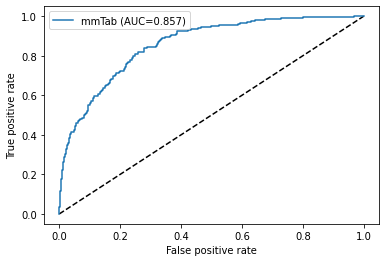

In [28]:
plot_result(df_temporal_results['death_hosp'], df_temporal_results['preds'])


Test Set...
Total batches: 80
Batch 80
Prediction complete.


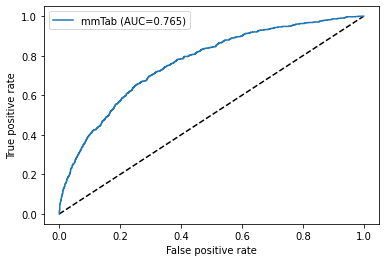

In [29]:
externalpreds = test_model(model, externaldata)
plot_result(df_external['death_hosp'], externalpreds[0])

In [30]:

# torch.save(model.state_dict(), "final_model_compare_param.pth")